# Actividad práctica: Predicción de series de tiempo

En esta tarea se pide entrenar y evaluar un predictor para la serie de tiempo Mackey-Glass. Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = 0.2 \frac{ y(t-\tau)}{1 + y(t-\tau)^{10}} - 0.1 y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

- Siga las instrucciones en este notebook para resolver el problema de predicción
- Conteste las preguntas que se encuentran en este enunciado
- Finalmente envíe su notebook con los resultados y respuestas a phuijse@inf.uach.cl
- No olvide cambiar el título para reflejar los integrantes de su grupo

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

***

Use el código que se muestra a continuación para generar la serie de tiempo Mackey Glass

- Considere una razón señal a ruido (SNR) de 2.
- Considere $\tau=17$ (comportamiento debilmente caótico)

Se generaran 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar y los siguientes 500 puntos para hacer predicción

<IPython.core.display.Javascript object>


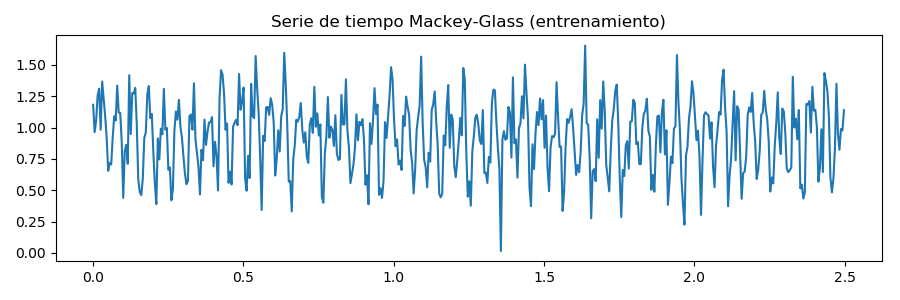

In [2]:
N = 1000 # número de observaciones (no modificar)
SNR = 2. # Razón señal a ruido (2., 0.5)
a, b = 0.1, 0.2 # constantes de la ecuación diferencial (no modificar)
tau = 17. # comportamiento dinámico de Mackey-Glass (17, 30)
dt = 0.05# paso de integración (no modificar)
y0 = 0.9 # condición incial (no modificar)
tt = 5.# largo temporal (no modificar)

t = np.linspace(0, tt, num=N)
#arreglo empieza en 0, termina en tt, N muestras

N_full, tau_full = int(N*tt/dt), int(tau/dt)

ymg = y0*np.ones(shape=(N_full, ))


# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;


ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 


# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))


# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

***

1. Describa en detalle el algoritmo LMS indicando sus semejanzas y diferencias con el filtro de Wiener
    
El algoritmo LMS(del ingles Least-Mean-Square) es un algoritmo usado en filtros adaptativos para encontrar los coeficientes del filtro que permiten obtener el valor minimo esperado del cuadrado de la señal de error (diferencia entre la señal deseada y la señal producida por el filtro). Pertenece a la familia de algoritmos de gradiente estocasticos, es decir, el filtro se adapta en base al gradiente de la tendencia estadistica, que se produce al relacionar la señal a filtrar con la señal de ruido. Es la aplicacion de un filtro FIR. Es el algoritmo mas simple (o estandar) de los algoritmos adaptivos, su objetivo consiste en la reduccion de ruido (usando metodos estadisticos) en la señal que tomamos como entrada ,para que la salida se aproxime lo mas posible a la señal que queremos obtener, es decir la señal deseada.

El algoritmo LMS tiene 2 prcesos basicos:
 * proceso de filtrado : Filtrado de la señal de entrada, se realiza un calculo de la salida generada por un filtro y la generación del error comparando dicha salida con la respuesta deseada.
 * proceso adaptativo : se hace un ajuste de los coeficientes del filtro de forma automatica según la estimación del error.
 
La solución del filtro LMS converge a la solución del filtro de Wiener , asumiendo que la solución del sistema desconocido es LTI y el ruido es estacionario, ambos filros se pueden utilizar para identificar la respuesta al impulso de un sistema desconocido, conociendo solamente la señal de entrada original y la salida del sistema desconocido. Al mitigar el criterio de error para reducir el error muestral actual en vez de minimizar el error total a lo largo de todo n, el algoritmo de LMS puede ser derivado del filtro de Wiener.

Ambos filtros son estimadores/Predictores, los 2 tratan de estimar los coeficientes del filtro lineal que minimiza la funcion de costo MMSE(minimum mean square error).

El filtro de Wiener asume la data (muestra de entrenamiento) ya dada para asi calcular una solución optima,en cambio LMS es una solución sub-optima ya que solo calcula el optimo en el instante (optimo local) ya que con su capacidad de automejorarse recursivamente en tiempo real (sin volver a ejecutar el algoritmo completo con información nueva, se logra obtener un costo de rendimiento (en cuanto a optimización) mucho mejor en comparación con el filtro de Wiener. 


2. Partiendo del error instantaneo $J_n^s(\textbf{w}) = e_n^2$ derive la regla de actualización de pesos
Partiendo de:

\begin{align}
J^s_n(\textbf{w}) &= e_n^2 \nonumber \\
&= (d_n - y_n)^2 \nonumber \\
&= (d_n - \sum_{k=0}^{L} w_{n, k} u_{n-k} )^2 \nonumber  \\ 
\tag{1} 
\end{align}

Calculando la derivada se tiene que:

\begin{equation}
\frac{dJ(w)}{dw} =   2 (d_n - \sum_{k=0}^{L} w_{n, k} u_{n-k})  u_{n-k}
\tag{2}
\end{equation}

Y recordando que 

\begin{equation}
e_n = d_n - y_n
\tag{3}
\end{equation}

Sustituyendo (3) en (2) tenemos la siguiente expresión:

\begin{equation}
\frac{dJ(w)}{dw} =   2 e_n u_{n-k}
\end{equation}

Y sea $w_n$ el peso de los coeficientes en el filtro y $\mu$ como tasa de aprendizaje o "paso", usando SGD (ya que como estamos calculando para LMS que es una versión mas simplista del filtro de Wiener) " $J_n^s(\textbf{w}) = e_n^2$" tenemos que:

\begin{equation}
w_{t+1} = w_t - \mu \frac{dJ(w)}{dw}
\tag{4}
\end{equation}

Finalmente, reemplazando en (4) obtenemos que la regla de actualización de pesos es:

\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu e_n \textbf{u}_{n-k}\nonumber \\
\end{align}

3. La siguiente clase de *Python* predice y entrena un filtro LMS. Complete la línea que dice 

` self.w = ? `

con el valor correcto de actualización de peso del filtro LMS

\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu e_n \textbf{u}_{n-k}\nonumber \\
\end{align}

In [3]:
class LMS_filter(object):
    
    def __init__(self, L=1, mu=0.5, normalized=True):
        self.L = L
        self.mu = mu
        self.w = np.zeros(shape=(L, ))
        self.normalized = normalized
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)#producto punto de W y U
    
    def update(self, u, d):
        d_pred = self.predict(u)
        norm = 1.
        if self.normalized:
            norm = np.sum(u**2) + 1e-6
        e = (d-d_pred)
        self.w = self.w + 2*self.mu*e*u

***
## Predicción con algoritmo LMS

1. Entrene el predictor con el algoritmo normalized LMS usando el siguiente bloque de código
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\mu$ y $L$
    - Se recomienda hacer un barrido logarítmico en $\mu$ (por ejemplo `mu=np.logspace(-2, 0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
***

1. Repita el experimento para $\tau = 30$ (comportamiento fuertemente caótico) 
1. Compare los resultados obtenidos con cada serie de tiempo. ¿Qué casos son más sencillos y cuales más complicados?


Usando L = 5,  $\tau = 17$

In [5]:
lms = LMS_filter(L=5, mu=0.09, normalized=True)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(lms.__len__(), 500):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    lms.update(u=y_window, d=y_obs[k])
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 786.1872, prueba 568.7694


<IPython.core.display.Javascript object>


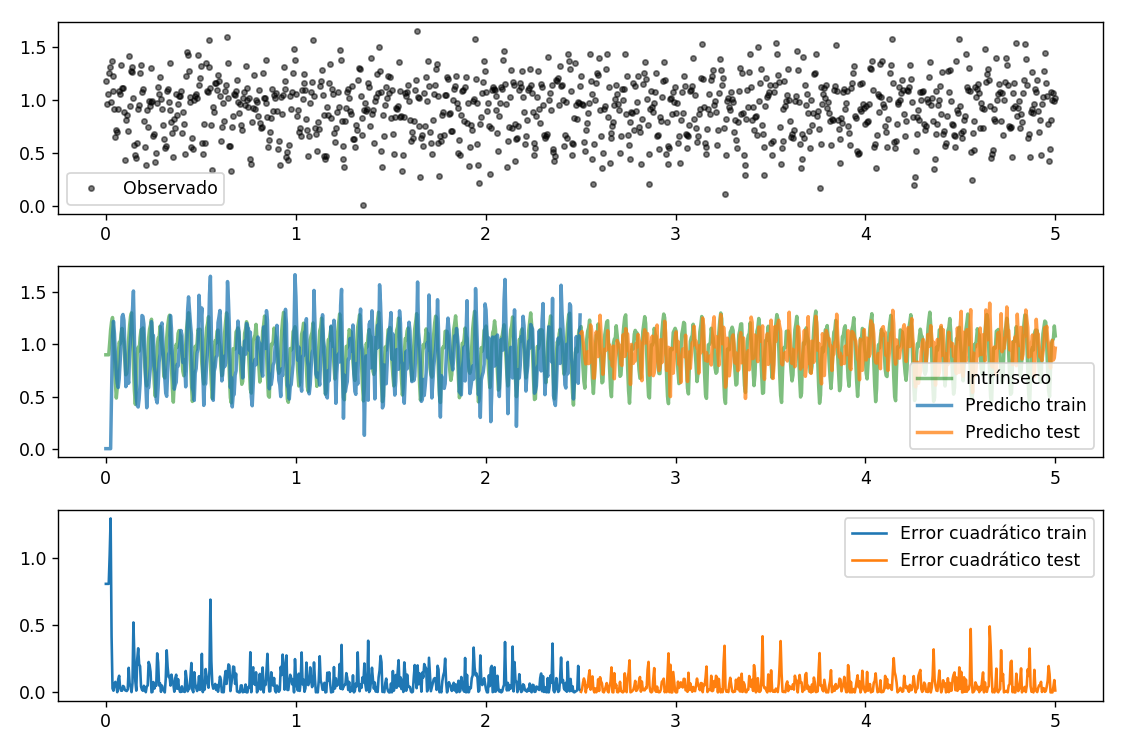

In [63]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

usando L= 10,  $\tau = 17$

In [64]:
lms = LMS_filter(L=10, mu=0.09, normalized=True)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(lms.__len__(), 500):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    lms.update(u=y_window, d=y_obs[k])
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 466.7278, prueba 664.4383


<IPython.core.display.Javascript object>


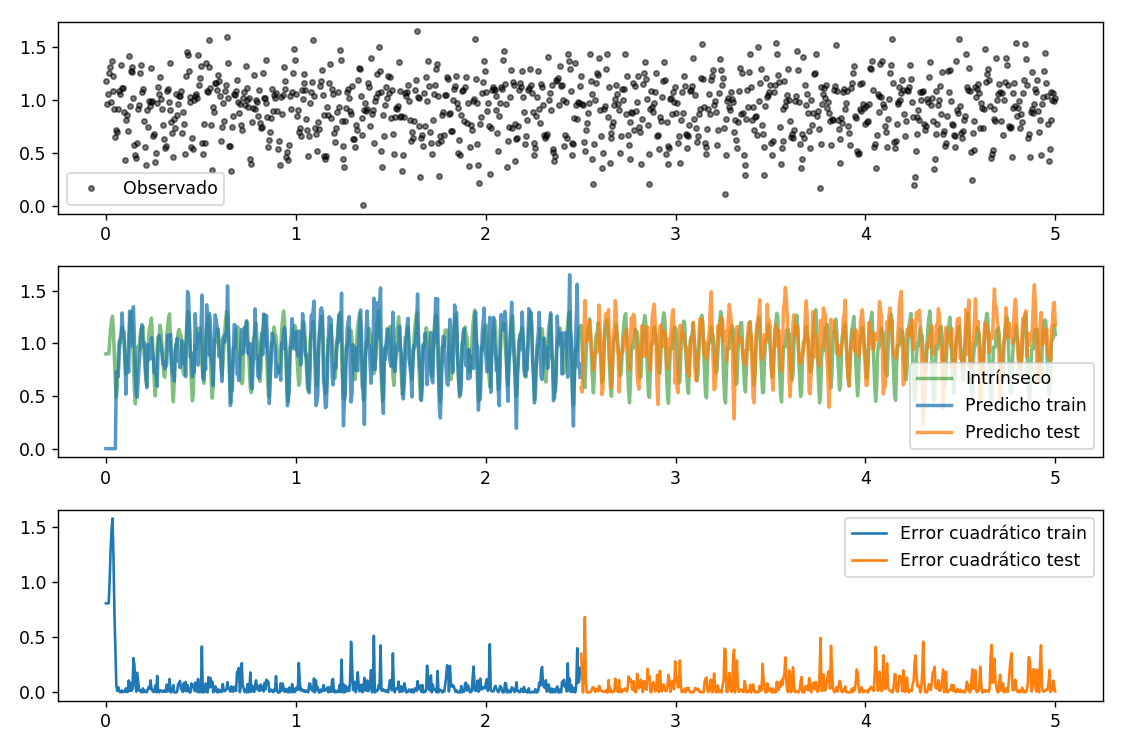

In [65]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

usando L= 20,  $\tau = 17$

In [66]:
lms = LMS_filter(L=20, mu=0.09, normalized=True)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(lms.__len__(), 500):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    lms.update(u=y_window, d=y_obs[k])
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 718.0094, prueba 1312.7511


<IPython.core.display.Javascript object>


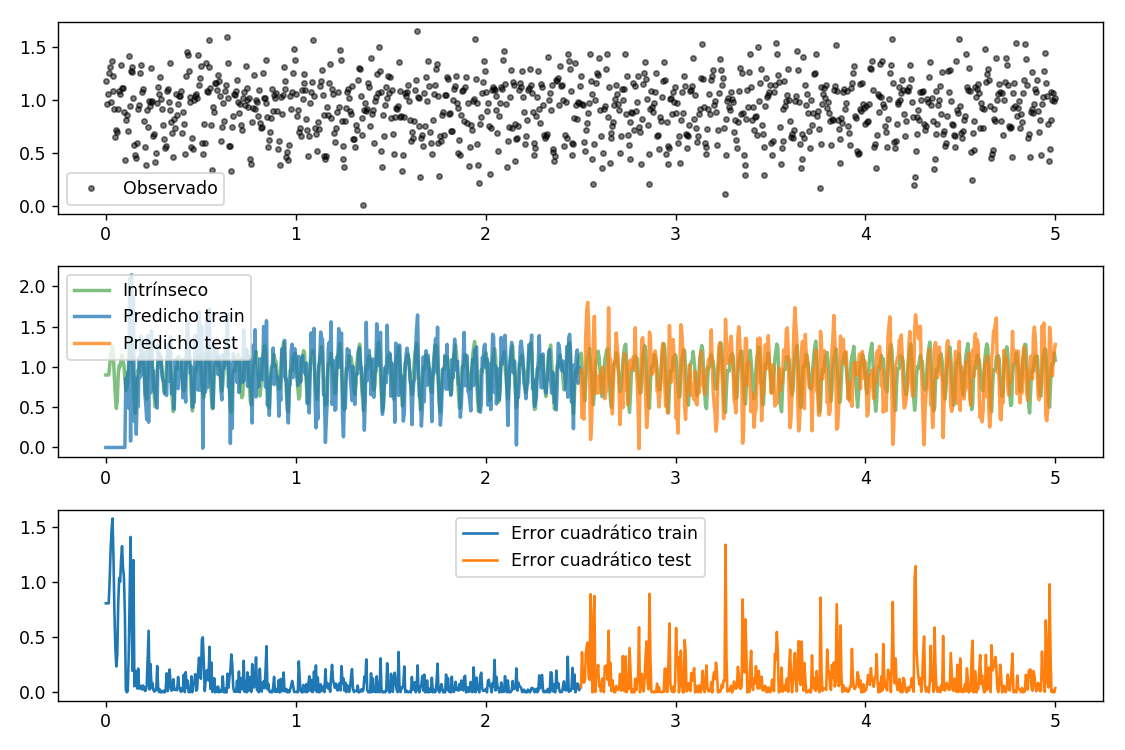

In [67]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

usando L= 30,  $\tau = 17$

In [68]:
lms = LMS_filter(L=30, mu=0.09, normalized=True)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(lms.__len__(), 500):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    lms.update(u=y_window, d=y_obs[k])
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 196536326726434221511434146543653909536906012571703131338764504868142446794541755665440152090366601968498298253538490604038620588458069706407936.0000, prueba 103470104868966058254824886143217632523059494140267595286612829161977496198366654243743035039984232627386036751326052127138584163295959563534073856.0000


<IPython.core.display.Javascript object>


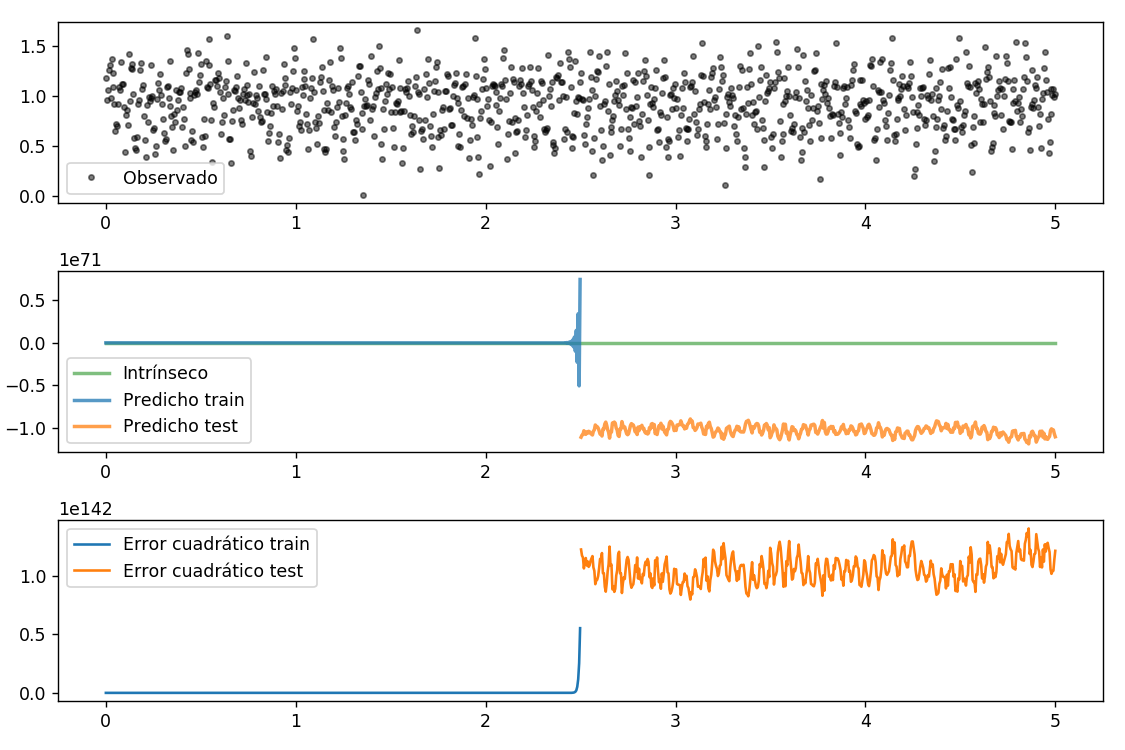

In [69]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

Ahora cambiar $\tau = 30$

<IPython.core.display.Javascript object>


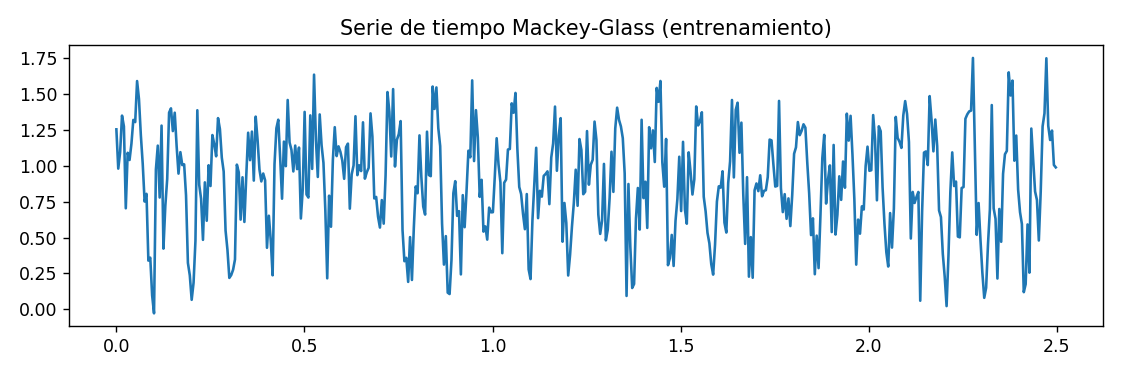

In [70]:
N = 1000 # número de observaciones (no modificar)
SNR = 2. # Razón señal a ruido (2., 0.5)
a, b = 0.1, 0.2 # constantes de la ecuación diferencial (no modificar)
tau = 30. # comportamiento dinámico de Mackey-Glass (17, 30)
dt = 0.05# paso de integración (no modificar)
y0 = 0.9 # condición incial (no modificar)
tt = 5.# largo temporal (no modificar)

t = np.linspace(0, tt, num=N)
#arreglo empieza en 0, termina en tt, N muestras

N_full, tau_full = int(N*tt/dt), int(tau/dt)

ymg = y0*np.ones(shape=(N_full, ))


# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;


ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 


# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))


# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

usando L=5 y $\tau = 30$

In [71]:
lms = LMS_filter(L=5, mu=0.09, normalized=True)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(lms.__len__(), 500):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    lms.update(u=y_window, d=y_obs[k])
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 524.3087, prueba 559.8093


<IPython.core.display.Javascript object>


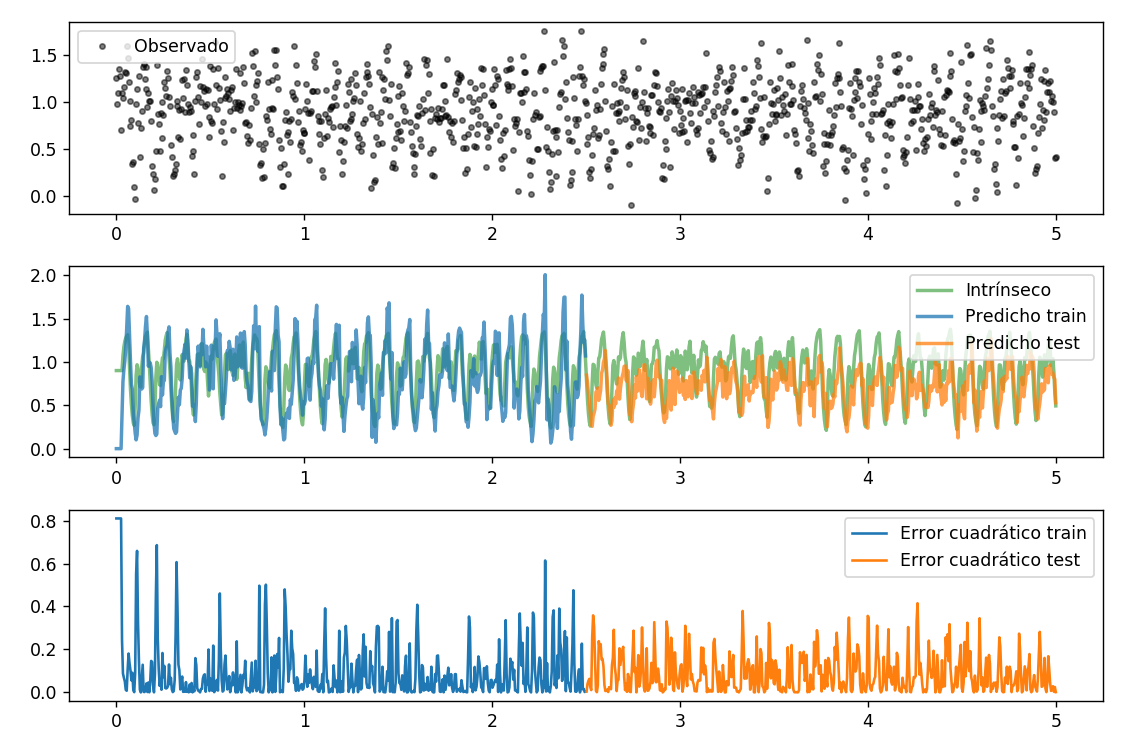

In [72]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

usando L=10 y $\tau = 30$

In [73]:
lms = LMS_filter(L=10, mu=0.09, normalized=True)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(lms.__len__(), 500):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    lms.update(u=y_window, d=y_obs[k])
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 656.7611, prueba 1227.4745


<IPython.core.display.Javascript object>


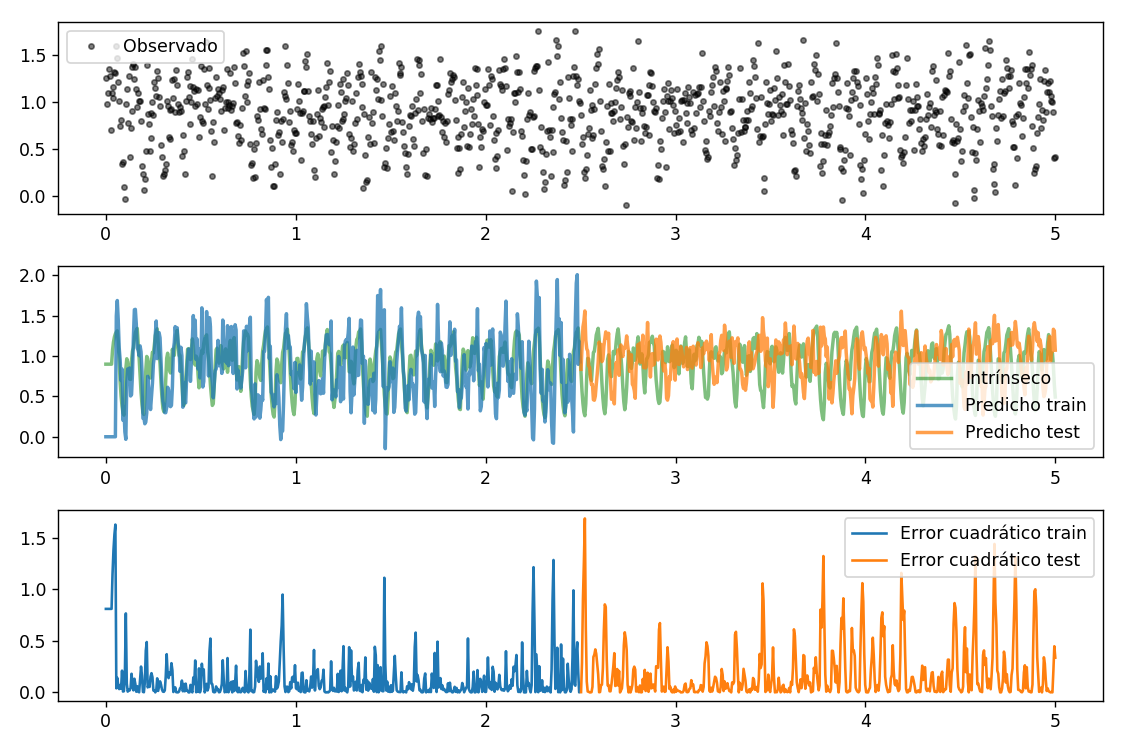

In [74]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

usando L=20 y $\tau = 30$

In [75]:
lms = LMS_filter(L=20, mu=0.09, normalized=True)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(lms.__len__(), 500):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    lms.update(u=y_window, d=y_obs[k])
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 991.5494, prueba 15379.6138


<IPython.core.display.Javascript object>


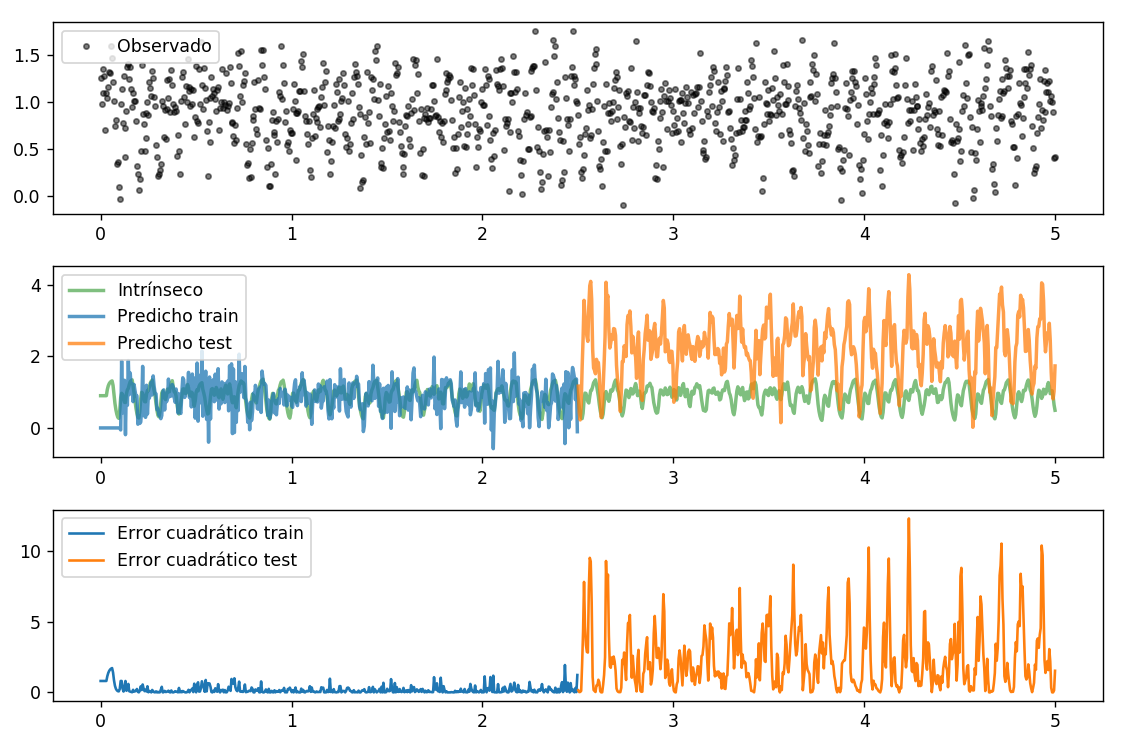

In [76]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

usando L=30 y $\tau = 30$

In [77]:
lms = LMS_filter(L=30, mu=0.09, normalized=True)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(lms.__len__(), 500):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    lms.update(u=y_window, d=y_obs[k])
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 54801248076453475930071990080250258667501962294449965875410206285521107849885753590312808403144754578457624576.0000, prueba 40870892484380101724764700664837207036162803290402842022371698034109582323985943468601555806853545461244430909440.0000


<IPython.core.display.Javascript object>


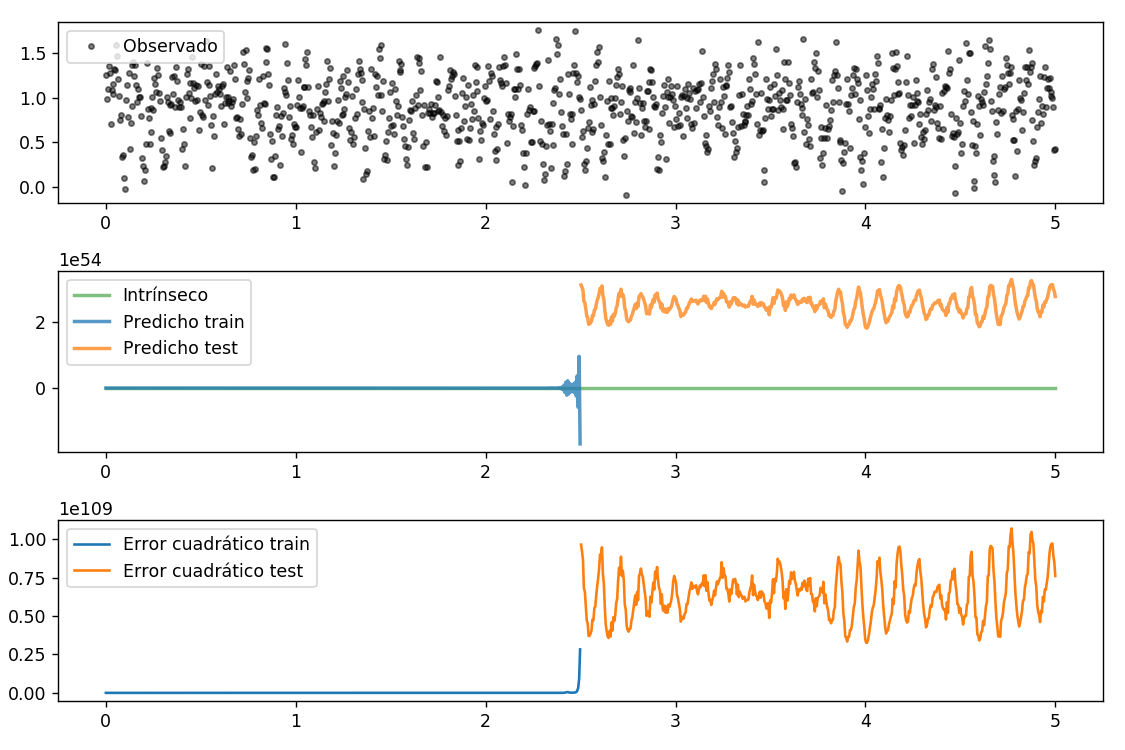

In [78]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

***
## Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS indicando sus semejanzas y diferencias con el algoritmo LMS

El algoritmo RLS se basa en el algoritmo LMS, pero ocupando caracteristicas acumulativas / recursivas, que permiten que el algoritmo se adapte mas rápido, lo que implica una convergencia más rápida del algoritmo.

Ambos son metodos sequenciales/onLine que resuelven el mismo problema,si la data previamente dada es estacionaria ambos metodos pueden converger a la misma solución.

Ambos pueden ajustarse con los datos , por lo tanto, son favorables cuando el sistema cambie en el tiempo.

La ventaja de RLS sobre LMS es que converge mas rápido a la solución. Su gran desventaja es que tiene mayor complejidad/costo computacional (O(L²) > O(L)).


2. Partiendo del error histórico $J_N(\textbf{w}) = \sum_{i=1}^N \beta^{N-i} e_i^2$ derive la regla recursiva de actualización de pesos 

Sea: 

\begin{align}
J^H_n(\textbf{w}) &= \sum_{i=L}^n   \beta^{n-i} |e_i|^2 \nonumber \\
\end{align}

Derivamos e igualamos a cero para obtener el optimo

$$
\begin{align}
\frac{d J^H_n (\textbf{w})}{d w_{n, k}} &= 2 \sum_{i=1}^n   \beta^{n-i} e_i \frac{de_i}{d w_{n, k}} = 0
\nonumber \\
\tag{1}
\end{align}
$$

Recordando que:
$$
\begin{align}
e_n = d_n - \sum_{k=0}^{L} w_{n, k} u_{n-k} \nonumber 
\tag{2}
\end{align}
$$
Y que:
$$
\begin{align}
\frac{de_i}{d w_{n, k}} &= u_{n-k}
\tag{3}
\end{align}
$$
Reemplazando (2) y (3) en (1) obtenemos:

$$
\begin{align}
\frac{d J^H_n (\textbf{w})}{d w_{n, k}} &= 2 \sum_{i=1}^n   \beta^{n-i} [d_i - \sum_{k=0}^{L} w_{n, k} u_{n-k}]u_{n-k} = 0
\nonumber \\
\end{align}
$$
Nos queda la siguiente ecuación:
$$
\begin{align}
\sum_{i=1}^n   \beta^{n-i} [d_i - \sum_{l=0}^{L} w_{n, k} u_{i-l}]u_{i-k} = 0
\nonumber \\
\tag{4}
\end{align}
$$

Reordenando la ecuacion (4) nos queda:
$$
\begin{align}
\sum_{l=1}^L  w_{n, k} [ \sum_{i=0}^{n}  \beta^{n-i} u_{i-l}u_{i-k}] = \sum_{i=0}^{n}  \beta^{n-i} d_i u_{i-k}
\nonumber \\
\tag{5}
\end{align}
$$

Definiendo las matrices que componen la solucion cerrada:

$$
\textbf{d}_n = \begin{pmatrix}  d_n \\ d_{n-1} \\ \vdots \\ d_{L+1} \end{pmatrix} \quad
\textbf{u}_n = \begin{pmatrix}  u_n \\ u_{n-1} \\ \vdots \\ u_{n-(L+1)} \end{pmatrix} \quad
\pmb{\beta} = I \begin{pmatrix} \beta \\ \beta^{1} \\ \beta^{2}  \vdots \\ \beta^{n-L-1} \end{pmatrix}
\quad 
U_n = \begin{pmatrix}
\textbf{u}_n^T \\ \textbf{u}_{n-1}^T \\ \vdots \\ \textbf{u}_{L+1}^T \\
\end{pmatrix} \in \mathbb{R}^{n - (L+1) \times L+1}
$$

Y agregando el regularizador de pesos:
$$
J^w_n = \delta  \| \textbf{w}_{n} \|^2
$$

Por lo que la forma matricial de la ecuación (5)(solución cerrada):

$$
\textbf{w}_n (U_n^T \pmb{\beta} U_n + \delta I) = U_n^T \pmb{\beta} \textbf{d}_n $$


$$
\textbf{w}_n = (U_n^T \pmb{\beta} U_n + \delta I)^{-1} U_n^T \pmb{\beta} \textbf{d}_n$$

Expresar la forma matricial enterminos mas simples:  

  - Matriz de correlación ponderada y regularizada: $\Phi_n = U_n^T \pmb{\beta} U_n + \delta I$
  - Vector de correlación cruzada ponderada:  $\theta_n = U_n^T \pmb{\beta} \textbf{d}_n$
  
Quedando finalmente:
$$
\begin{align}
\textbf{w}_n = \Phi_n^{-1} \theta_n
\end{align}
$$

3. La siguiente clase de *Python* predice y entrena un filtro RLS. Complete las líneas que dice 

` self.w = ? ` y `self.Phi_inv = `

con el valor correcto de actualización de peso del filtro RLS

$$
\textbf{w}_n = \textbf{w}_{n-1} + \textbf{k}_n e_n 
$$
    
$$
\Phi_{n}^{-1} = \beta^{-1} \Phi_{n-1}^{-1} - \beta^{-1} \textbf{k}_n \textbf{u}_n^T \Phi_{n-1}^{-1}
$$

In [8]:
class RLS_filter(object):
    
    def __init__(self, L=1, beta=0.9, delta=10.):
        self.L = L
        self.beta = beta
        self.w = np.zeros(shape=(L, ))
        self.Phi_inv = delta*np.eye(L)
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):          
        invbeta = 1.0/self.beta
        d_pred = self.predict(u)
        e = d - d_pred
        r = 1. + invbeta*np.dot(np.dot(u, self.Phi_inv), u.T)
        k = invbeta*np.dot(self.Phi_inv, u)/r       
        self.Phi_inv = invbeta*self.Phi_inv - invbeta*k*d_pred*self.Phi_inv
        self.w = self.w + k*e
        

***

1. Entrene el predictor con el algoritmo RLS usando el siguiente bloque de código
1. Considere primero  $\tau=17$
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\beta$ y $L$
    - Se recomienda hacer un barrido lineal en $\beta$ (por ejemplo `mu=np.linspace(0.8, 1.0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Cuánto demora el filtro en estabilizarse? 
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
1. Repita el experimento para $\tau=30$
1. Compare con los resultados obtenidos con el algoritmo LMS ¿Qué algoritmo demora menos en converger?


usando L=5 y $\tau = 17$

In [20]:
rls = RLS_filter(L=5, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 238.6437, prueba 606.3019


<IPython.core.display.Javascript object>


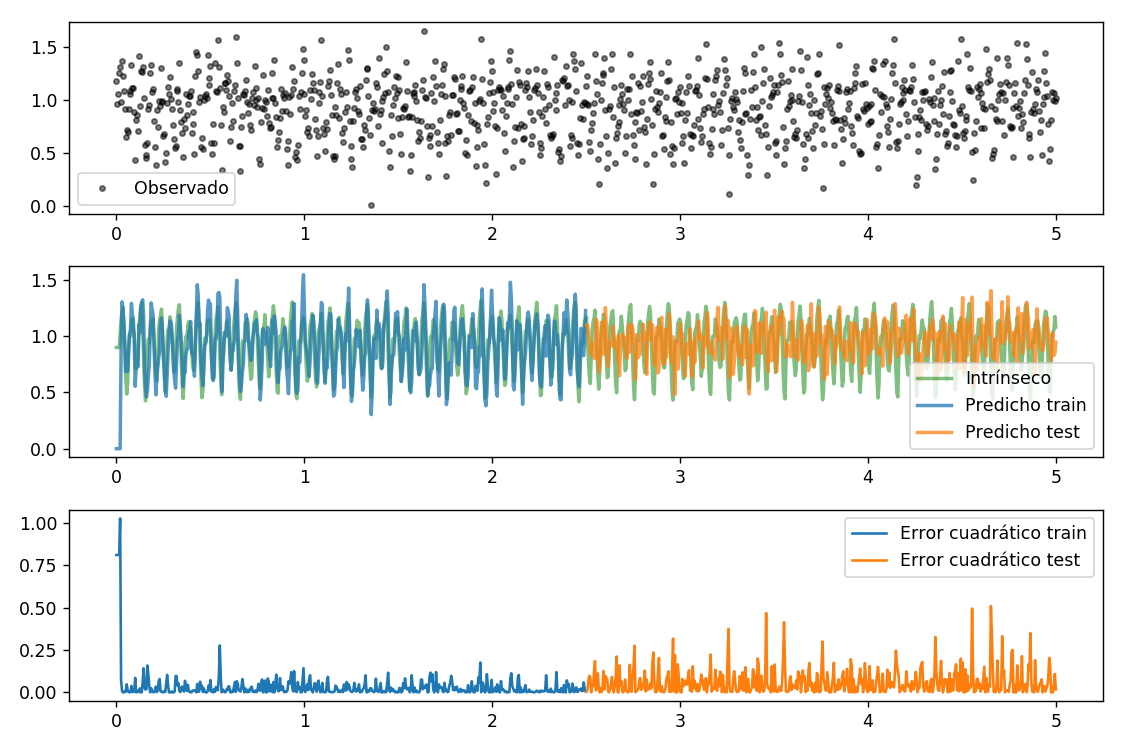

In [21]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

usando L=10 y $\tau = 17$

In [23]:
rls = RLS_filter(L=10, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 233.2099, prueba 1094.7570


<IPython.core.display.Javascript object>


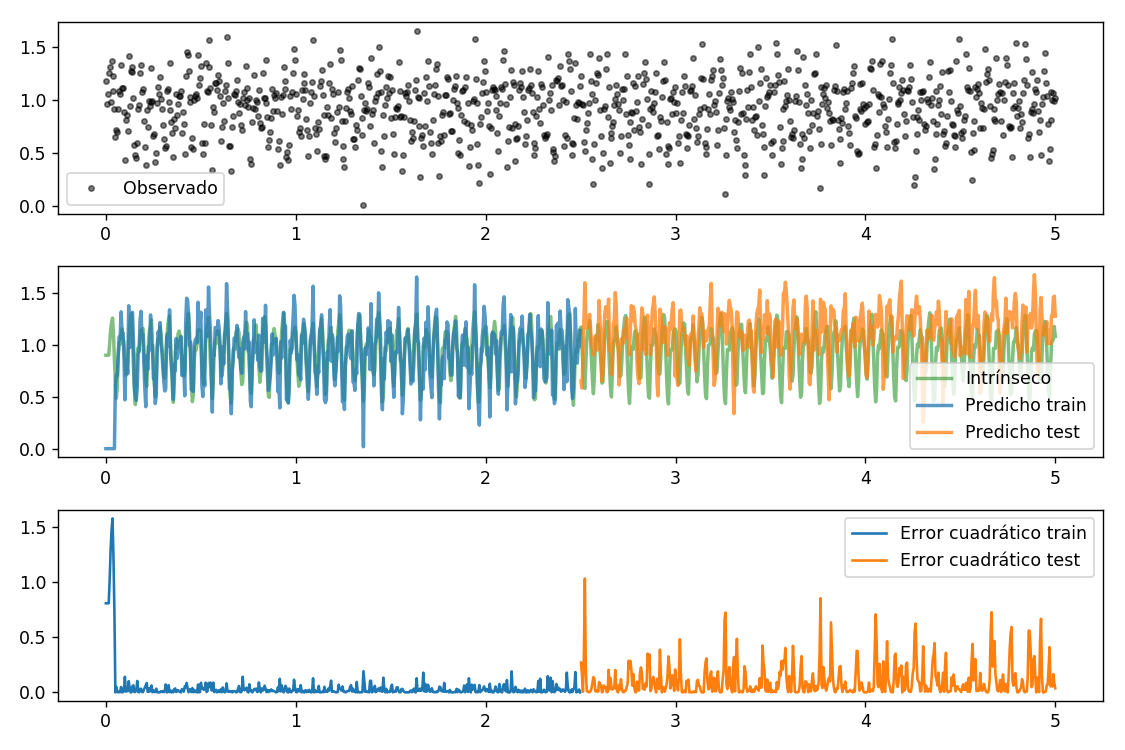

In [24]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

usando L=20 y $\tau = 17$

In [25]:
rls = RLS_filter(L=20, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 236.1840, prueba 475.3396


<IPython.core.display.Javascript object>


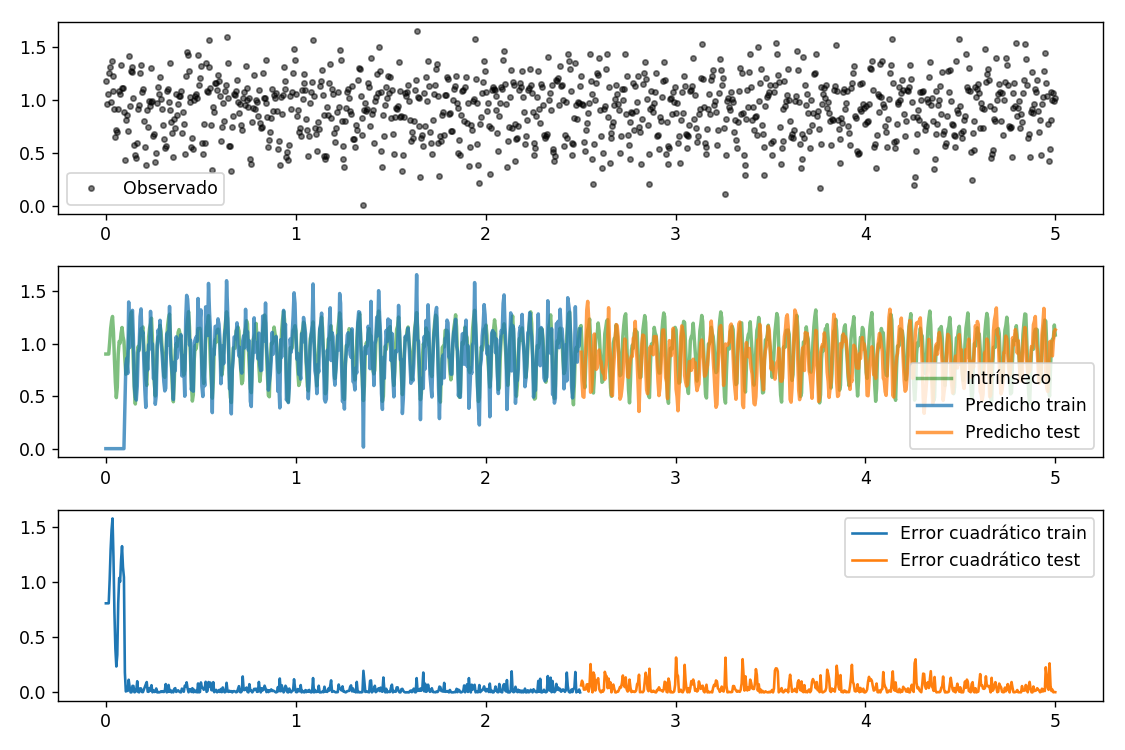

In [26]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

usando L=30 y $\tau = 17$

In [27]:
rls = RLS_filter(L=30, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 226.1382, prueba 345.8687


<IPython.core.display.Javascript object>


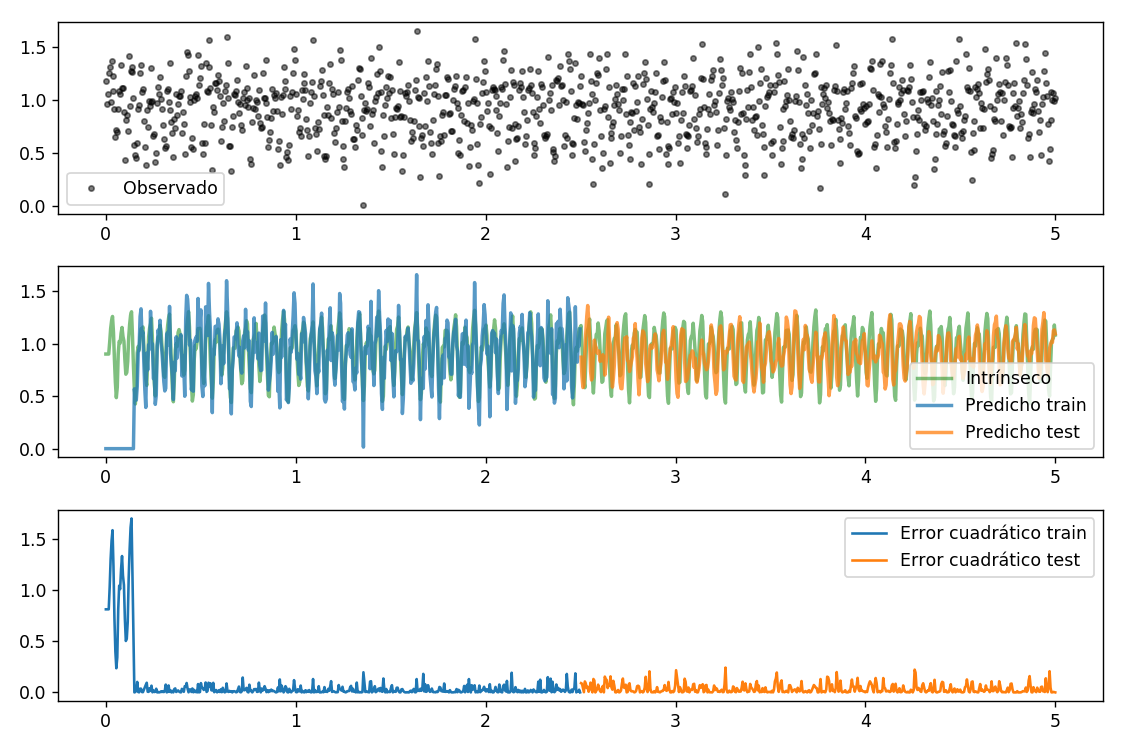

In [28]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

<IPython.core.display.Javascript object>


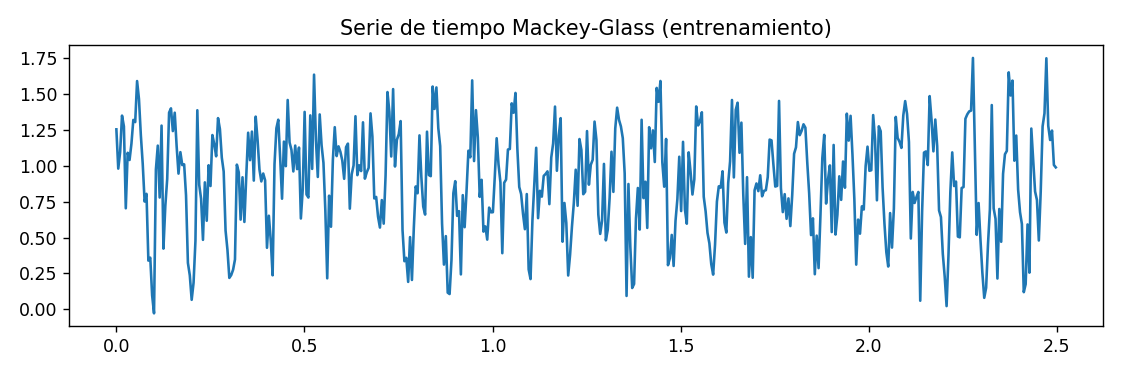

In [29]:
N = 1000 # número de observaciones (no modificar)
SNR = 2. # Razón señal a ruido (2., 0.5)
a, b = 0.1, 0.2 # constantes de la ecuación diferencial (no modificar)
tau = 30. # comportamiento dinámico de Mackey-Glass (17, 30)
dt = 0.05# paso de integración (no modificar)
y0 = 0.9 # condición incial (no modificar)
tt = 5.# largo temporal (no modificar)

t = np.linspace(0, tt, num=N)
#arreglo empieza en 0, termina en tt, N muestras

N_full, tau_full = int(N*tt/dt), int(tau/dt)

ymg = y0*np.ones(shape=(N_full, ))


# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;


ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 


# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))


# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

usando L=5 y $\tau = 30$

In [30]:
rls = RLS_filter(L=5, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 212.5978, prueba 617.3084


<IPython.core.display.Javascript object>


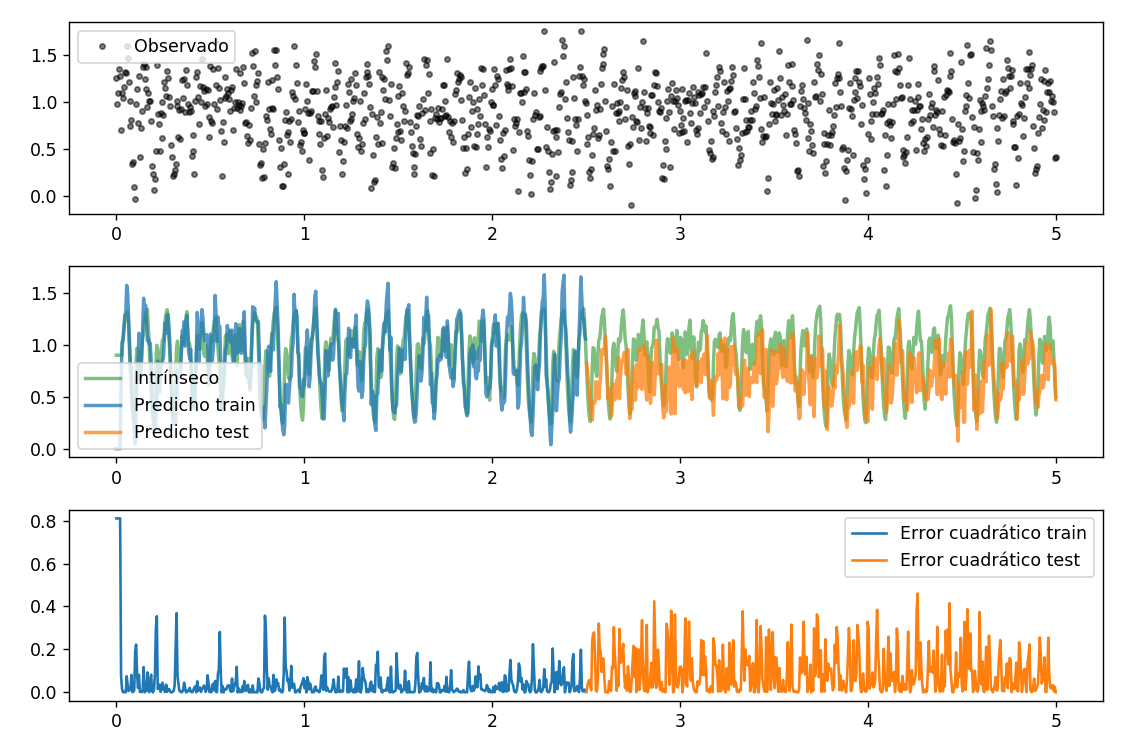

In [31]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

usando L=10 y $\tau = 30$

In [32]:
rls = RLS_filter(L=10, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 225.7695, prueba 2183.2111


<IPython.core.display.Javascript object>


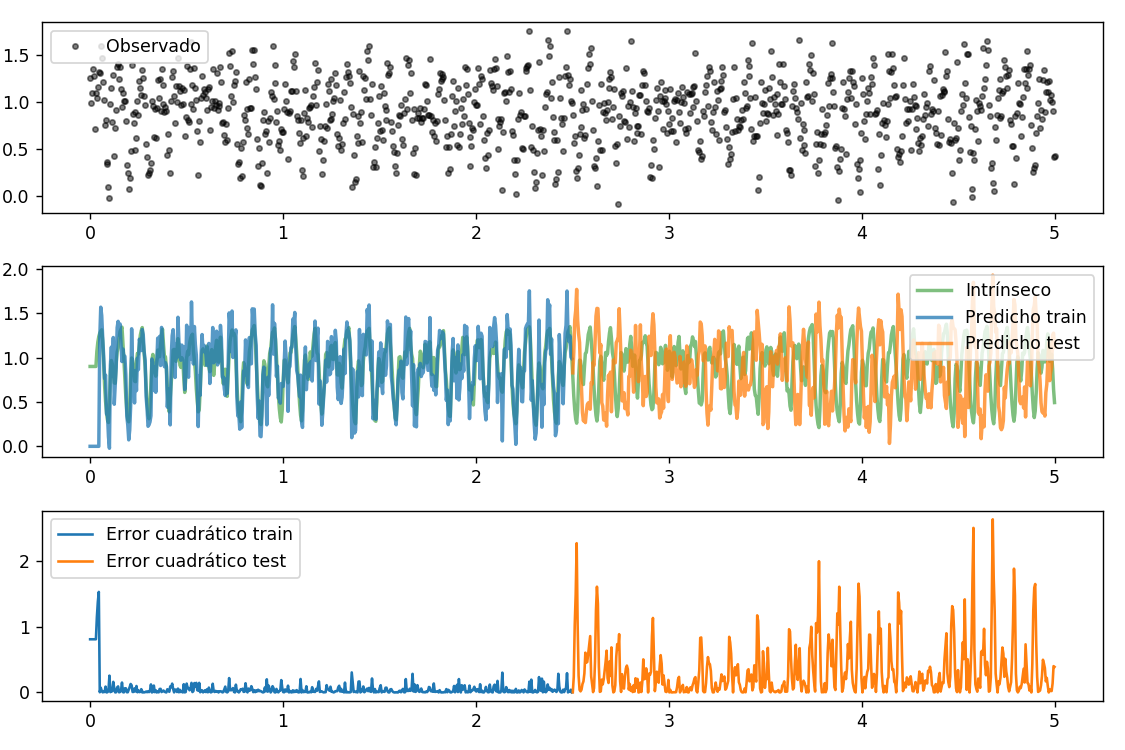

In [33]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

usando L=20 y $\tau = 30$

In [34]:
rls = RLS_filter(L=20, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 232.8087, prueba 2345.3333


<IPython.core.display.Javascript object>


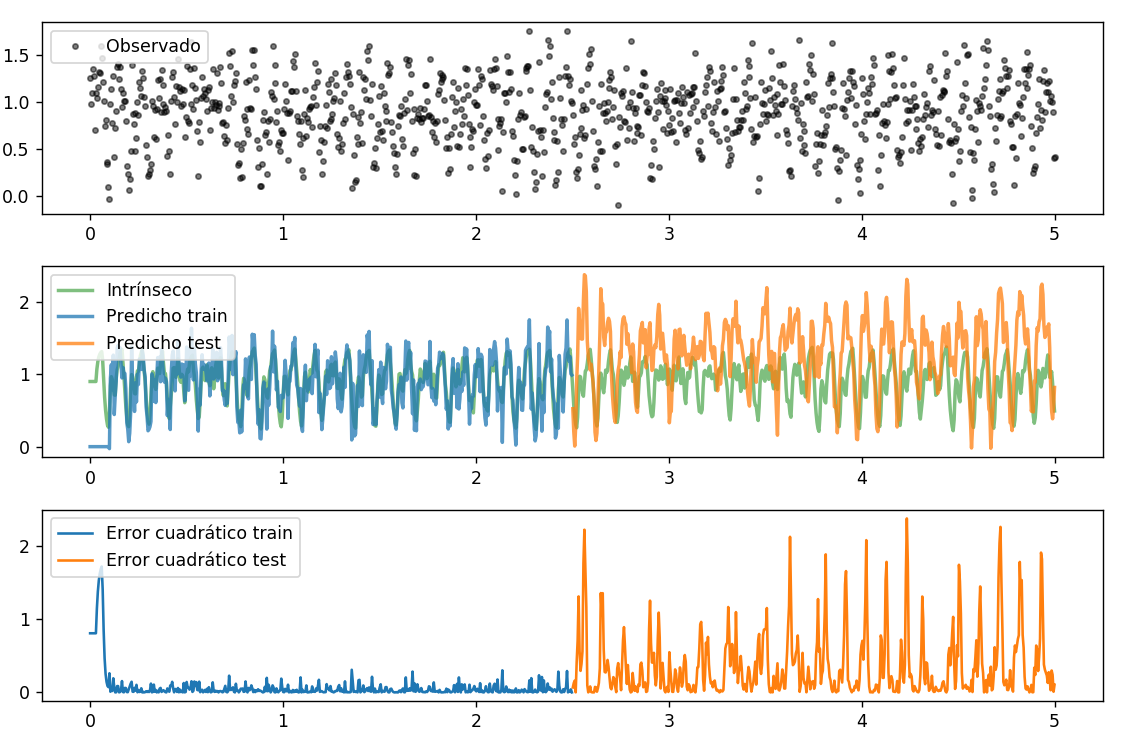

In [35]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

usando L=30 y $\tau = 30$

In [36]:
rls = RLS_filter(L=20, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 232.8087, prueba 2345.3333


<IPython.core.display.Javascript object>


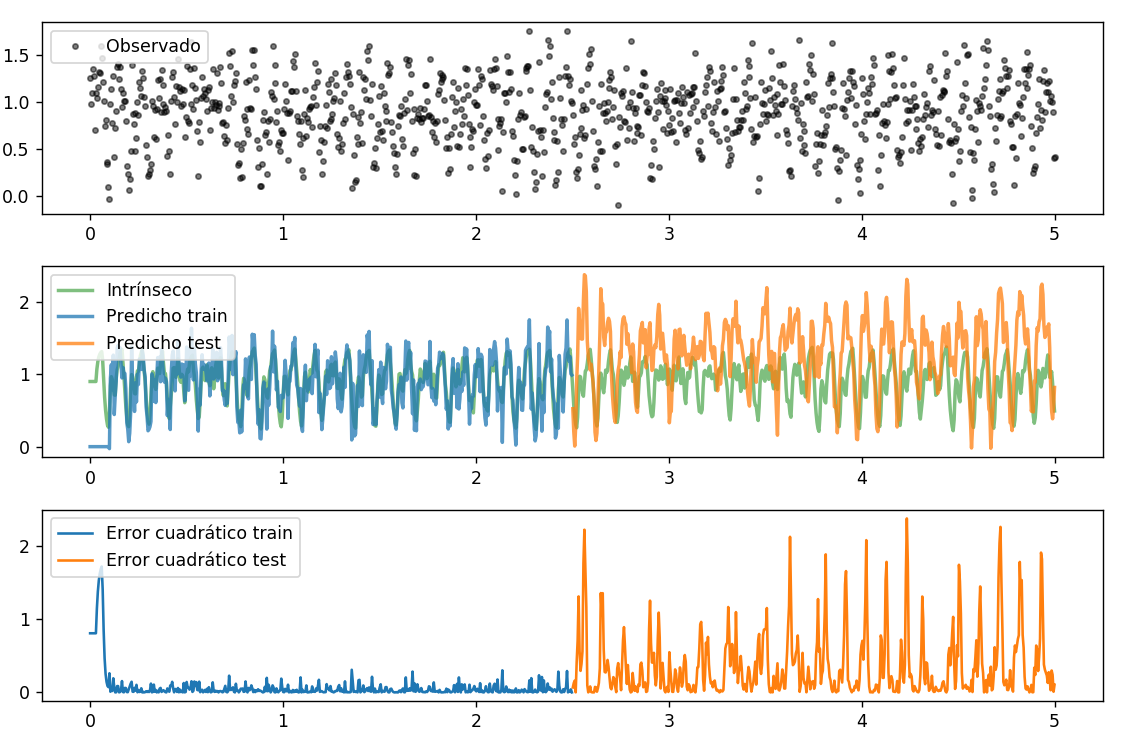

In [37]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)